In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.utils as vutils
from collections import namedtuple
from encoder import Encoder
from encoder_vgg19 import EncoderVGG19
from encoder_vision_transformer import EncoderVisionTransformer
from encoder_efficient_net_v2 import EncoderEfficientNetV2
from decoder import Decoder
from verifiier import Verifier

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
LATENT_SPACE_SIZE = 128
IMAGE_SIZE = 224

device = 'cuda:0'
ngpu = 4
TRAIN_SPLIT = 0.9

In [3]:
def normalize_gaussian(x):
    return (x - x.mean()) / (x.std() + 0.00000001)

def normalize_minmax(x):
    x = (x - x.min())
    return x / x.max()

def random_noise(size):
    return torch.rand(size)

def normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    transform = torchvision.transforms.Normalize(mean, std)
    return transform(tensor)

In [4]:
def display_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image.cpu()
    image = torch.clip(image * torch.FloatTensor(std) + torch.FloatTensor(mean), 0, 1)
    plt.imshow(image)
    plt.show()

In [5]:
class DatasetWrapper(torch.utils.data.Dataset):

    def __init__(self, dataset, idxs, transform):
        self.idxs = idxs
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        pair_a, pair_b, label = self.dataset[self.idxs[idx]]
        return self.transform(pair_a), self.transform(pair_b), label

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation((-10, 10)),
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = torchvision.datasets.LFWPairs(root='.data/', split='train', download=True)

perm = torch.randperm(len(dataset))
train_k = int(len(dataset) * TRAIN_SPLIT)
train_split = perm[:train_k]
val_split = perm[train_k:]

train_dataset = DatasetWrapper(dataset, train_split, train_transform)
val_dataset = DatasetWrapper(dataset, val_split, val_transform)
test_dataset = torchvision.datasets.LFWPairs(root='.data/', split='test', download=True, transform=test_transform)

print('Train length: %d' % len(train_dataset))
print('Val length: %d' % len(val_dataset))
print('Test length: %d' % len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Train length: 1980
Val length: 220
Test length: 1000


In [7]:
print('Train - Shape: %s' % (train_dataset[0][0].shape,))
print('Train - Mean: %.4f' % train_dataset[0][0].mean())
print('Train - Std: %.4f' % train_dataset[0][0].std())
print('Train - Min: %.4f' % train_dataset[0][0].min())
print('Train - Max: %.4f' % train_dataset[0][0].max())

print('Val - Shape: %s' % (val_dataset[0][0].shape,))
print('Val - Mean: %.4f' % val_dataset[0][0].mean())
print('Val - Std: %.4f' % val_dataset[0][0].std())
print('Val - Min: %.4f' % val_dataset[0][0].min())
print('Val - Max: %.4f' % val_dataset[0][0].max())

print('Test - Shape: %s' % (test_dataset[0][0].shape,))
print('Test - Mean: %.4f' % test_dataset[0][0].mean())
print('Test - Std: %.4f' % test_dataset[0][0].std())
print('Test - Min: %.4f' % test_dataset[0][0].min())
print('Test - Max: %.4f' % test_dataset[0][0].max())

Train - Shape: torch.Size([3, 224, 224])
Train - Mean: 0.4899
Train - Std: 0.5693
Train - Min: -1.8431
Train - Max: 2.1804
Val - Shape: torch.Size([3, 224, 224])
Val - Mean: -0.4968
Val - Std: 1.0793
Val - Min: -2.1179
Val - Max: 2.6400
Test - Shape: torch.Size([3, 224, 224])
Test - Mean: 0.0722
Test - Std: 1.2806
Test - Min: -2.1179
Test - Max: 2.6226


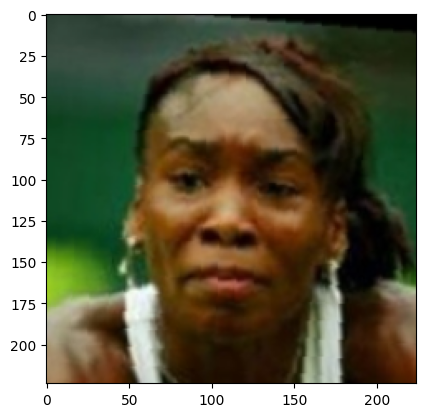

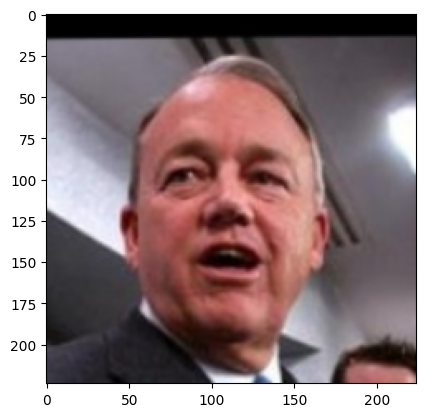

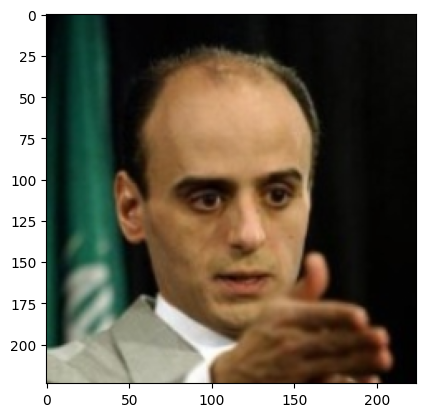

In [8]:
display_image(train_dataset[3][0].permute(1, 2, 0))
display_image(val_dataset[3][0].permute(1, 2, 0))
display_image(test_dataset[3][0].permute(1, 2, 0))

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [10]:
# Create the Encoder
encoder = EncoderVisionTransformer(LATENT_SPACE_SIZE).to(device)

# Handle multi-gpu if desired
if (ngpu > 1):
    encoder = torch.nn.DataParallel(encoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# encoder.apply(weights_init)

# encoder.load_state_dict(torch.load('.models/pair/encoder-vt-224.pt'))

# Print the model
print(encoder)

DataParallel(
  (module): EncoderVisionTransformer(
    (model): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (encoder): Encoder(
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.1, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.1, inplace=False)
         

In [11]:
# Create the Verifier
verifier = Verifier(LATENT_SPACE_SIZE).to(device)

# Handle multi-gpu if desired
if (ngpu > 1):
    verifier = torch.nn.DataParallel(verifier, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# verifier.apply(weights_init)

# verifier.load_state_dict(torch.load('.models/pair/verifier-224.pt'))

# Print the model
print(verifier)

DataParallel(
  (module): Verifier(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=512, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
)


In [12]:
# Generator Code

class Generator(torch.nn.Module):
    def __init__(self, latent_space_size):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(latent_space_size, 256, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),

            torch.nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
generator = Generator(128).to(device)

# Handle multi-gpu if desired
if (ngpu > 1):
    generator = torch.nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
# generator.apply(weights_init)

# generator.load_state_dict(torch.load('.models/pair/generator-224.pt'))

# Print the model
print(generator)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2),

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(3, 8, 4, 2, 1, bias=False), # 112x112
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(8, 16, 4, 2, 1, bias=False), # 56x56
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(16, 32, 4, 2, 1, bias=False), # 28x28
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(32, 64, 4, 2, 1, bias=False), # 14x14
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(64, 128, 4, 2, 1, bias=False), # 7x7
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(128, 256, 4, 2, 1, bias=False), # 3x3
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),

            torch.nn.Conv2d(256, 1, 3, 1, 0, bias=False),  # 1x1
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the discriminator
discriminator = Discriminator().to(device)

# Handle multi-gpu if desired
if (ngpu > 1):
    discriminator = torch.nn.DataParallel(discriminator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
# discriminator.apply(weights_init)

# discriminator.load_state_dict(torch.load('.models/pair/discriminator-2.pt'))

# Print the model
print(discriminator)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fals

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=1)

In [17]:
def validate():
    encoder.eval()
    verifier.eval()
    generator.eval()
    discriminator.eval()
    
    with torch.no_grad():
        accuracy = []
        for i, data in enumerate(val_loader, 0):

            batch_size =  data[0].size(0)

            pairs_a = data[0].to(device)
            pairs_b = data[1].to(device)
            label = data[2].float().to(device)

            ############################
            # (1) Update E and V networks for true data
            ###########################

            latent_a = torch.flatten(encoder(pairs_a), start_dim=1)
            latent_b = torch.flatten(encoder(pairs_b), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            A_rv = ((output > 0.5) == (label == 1)).float().mean()
            accuracy.append(A_rv.item())

        print('Validation Accuracy: %.4f' % (sum(accuracy) / len(accuracy)))

    encoder.train()
    verifier.train()
    generator.train()
    discriminator.train()

    return sum(accuracy) / len(accuracy)

In [18]:
# Train mode
encoder.train()
verifier.train()
generator.train()
discriminator.train()

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 128, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizerVerifier = torch.optim.Adam(verifier.parameters(), lr=0.00001, betas=(0.5, 0.999))
optimizerGenerator = torch.optim.Adam(generator.parameters(), lr=0.00002, betas=(0.5, 0.999))
optimizerDiscriminator = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

In [19]:
img_list = []

def train():
    # Training Loop
    num_epochs = 1000

    # Lists to keep track of progress
    iters = 0

    best = validate()

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the train_loader
        for i, data in enumerate(train_loader, 0):

            batch_size =  data[0].size(0)

            pairs_a = data[0].to(device)
            pairs_b = data[1].to(device)
            label = data[2].float().to(device)

            ############################
            # (1) Update E and V networks
            ###########################

            optimizerEncoder.zero_grad()
            optimizerVerifier.zero_grad()

            latent_a = torch.flatten(encoder(pairs_a), start_dim=1)
            latent_b = torch.flatten(encoder(pairs_b), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            err_rv = criterion(output, label)
            err_rv.backward(retain_graph=True)

            A_rv = ((output > 0.5) == (label == 1)).float().mean()

            noise = torch.randn(batch_size, 128, 1, 1, device=device)
            fake_1 = normalize(generator(noise))
            label.fill_(0)

            latent_b = torch.flatten(encoder(fake_1.detach()), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            err_gv = criterion(output, label)
            err_gv.backward(retain_graph=True)

            A_gv = ((output > 0.5) == (label == 1)).float().mean()

            optimizerEncoder.step()
            optimizerVerifier.step()


            ############################
            # (2) Update D network
            ###########################

            optimizerDiscriminator.zero_grad()

            label.fill_(1)

            output = discriminator(pairs_a).view(-1)

            err_rd = criterion(output, label)

            err_rd.backward(retain_graph=True)

            A_rd = ((output > 0.5) == (label == 1)).float().mean()

            label.fill_(0)

            output = discriminator(fake_1.detach()).view(-1)

            err_gd = criterion(output, label)

            err_gd.backward()

            A_gd = ((output > 0.5) == (label == 1)).float().mean()

            optimizerDiscriminator.step()

            ############################
            # (4) Update G network
            ###########################
            
            optimizerGenerator.zero_grad()

            label.fill_(1)

            latent_a = torch.flatten(encoder(pairs_a).detach(), start_dim=1)
            latent_b = torch.flatten(encoder(fake_1), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            err_g_v = criterion(output, label)
            err_g_v.backward(retain_graph=True)

            A_g_v = ((output > 0.5) == (label == 1)).float().mean()

            output = discriminator(fake_1).view(-1)

            err_g_d = criterion(output, label)
            err_g_d.backward()

            A_g_d = ((output > 0.5) == (label == 1)).float().mean()

            optimizerGenerator.step()

            ############################
            # (5) Update G network
            ###########################
            
            optimizerGenerator.zero_grad()

            noise = torch.randn(batch_size, 128, 1, 1, device=device)
            fake_2 = normalize(generator(noise))

            latent_a = torch.flatten(encoder(pairs_a).detach(), start_dim=1)
            latent_b = torch.flatten(encoder(fake_2), start_dim=1)

            latent_diff = torch.pow(latent_a - latent_b, 2)

            output = verifier(latent_diff).view(-1)

            err_g_v = criterion(output, label)
            err_g_v.backward(retain_graph=True)

            A_g_v = ((output > 0.5) == (label == 1)).float().mean()

            output = discriminator(fake_2).view(-1)

            err_g_d = criterion(output, label)
            err_g_d.backward()

            A_g_d = ((output > 0.5) == (label == 1)).float().mean()

            optimizerGenerator.step()

            # Output training stats
            if i % 5 == 0:
                print('[%d/%d][%d/%d]\tLoss_V: %.4f\tLoss_D: %.4f\tLoss_G: %.4f\tAcc_V: %.4f\tAcc_D: %.4f\tAcc_G: %.4f'
                    % (epoch, num_epochs, i, len(train_loader), (err_rv.item() + err_gv.item()) / 2, (err_rd.item() + err_gd.item()) / 2, (err_g_v.item() + err_g_d.item()) / 2, (A_rv + A_gv) / 2, (A_rd + A_gd) / 2, (A_g_v + A_g_d) / 2))

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
        
        acc = validate()

        print("Current best validation accuracy: %.4f" % (best,))

        if acc >= best:
            best = acc
            torch.save(encoder.state_dict(), '.models/pair/encoder-vt-224-2.pt')
            torch.save(verifier.state_dict(), '.models/pair/verifier-224-2.pt')
            torch.save(generator.state_dict(), '.models/pair/generator-224-2.pt')
            torch.save(discriminator.state_dict(), '.models/pair/discriminator-224-2.pt')
            print("Saved best model.")

train()

Validation Accuracy: 0.4821
Starting Training Loop...


libibverbs: Warning: couldn't load driver 'librxe-rdmav34.so': librxe-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libmlx4-rdmav34.so': libmlx4-rdmav34.so: cannot open shared object file: No such file or directory


UnboundLocalError: local variable 'fake' referenced before assignment

In [17]:
encoder.eval()
verifier.eval()
generator.eval()

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2),

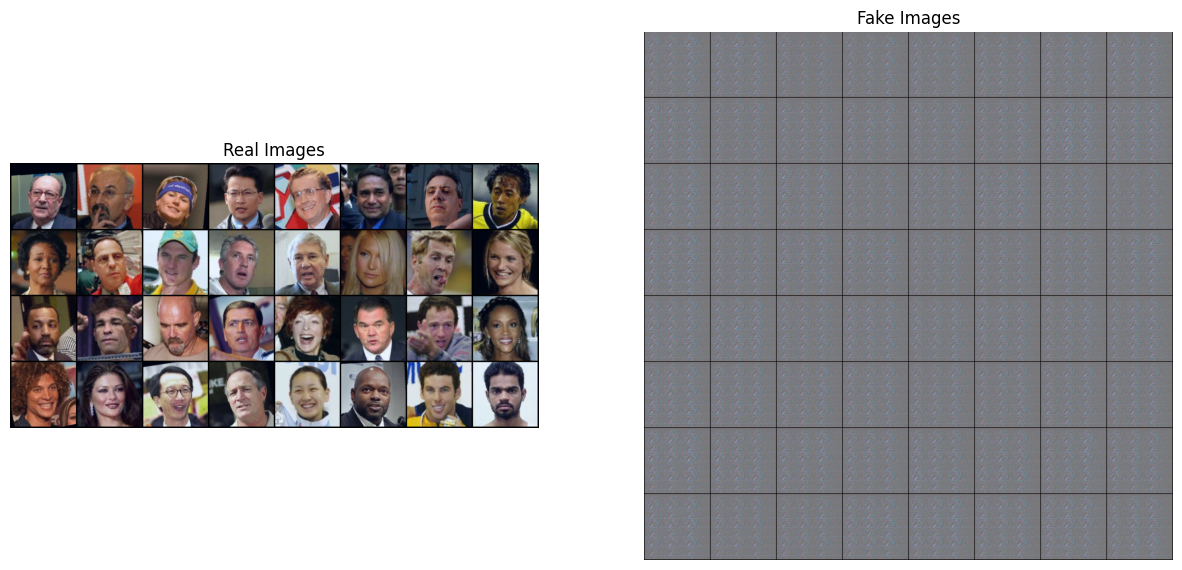

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Accuracy for batch 1: 0.7500
Accuracy for batch 2: 0.7656
Accuracy for batch 3: 0.7031
Accuracy for batch 4: 0.8125
Accuracy for batch 5: 0.8750
Accuracy for batch 6: 0.8438
Accuracy for batch 7: 0.7812
Accuracy for batch 8: 0.7656
Accuracy for batch 9: 0.8281
Accuracy for batch 10: 0.8906
Accuracy for batch 11: 0.7969
Accuracy for batch 12: 0.8281
Accuracy for batch 13: 0.8125
Accuracy for batch 14: 0.7969
Accuracy for batch 15: 0.7656
Accuracy for batch 16: 0.8250
Accuracy: 0.8025
